In [1]:
import torch
import torch_geometric

from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

In [2]:
import matplotlib as plt
import numpy as np
import networkx
from torch_geometric.data import Data
from sklearn.manifold import TSNE


In [3]:
from torch_geometric.utils import to_dense_adj

### Data Preprocessing

Dataset import

In [4]:
dataset = TUDataset(root="../dataset", name='PROTEINS')

In [5]:
insp = 3
print(dataset[insp+851])
print(dataset[insp+213])
print(dataset[insp+2]) 

Data(edge_index=[2, 52], x=[14, 3], y=[1])
Data(edge_index=[2, 230], x=[51, 3], y=[1])
Data(edge_index=[2, 1632], x=[336, 3], y=[1])


Create complementary graph

In [6]:
adj_o = to_dense_adj(dataset[2].edge_index)
adj_c = abs(to_dense_adj(dataset[2].edge_index) - 1) - torch.eye(len(dataset[2].x))

print("Original:", adj_o)
print("Complementary:", (adj_c))

Original: tensor([[[0., 1., 1., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 0., 1., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 1., 1., 1., 0.],
         [0., 0., 0., 0., 1., 1., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 1., 1., 0., 1., 0.],
         [0., 0., 0., 0., 0., 1., 1., 1., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0.]]])
Complementary: tensor([[[0., 0., 0., 1., 1., 1., 1., 1., 1., 0.],
         [0., 0., 0., 1., 1., 1., 1., 1., 1., 0.],
         [0., 0., 0., 0., 1., 1., 1., 1., 1., 0.],
         [1., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 1., 0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 1.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 1.],
    

In [7]:
print(adj_o[0].nonzero().t().contiguous() == dataset[2].edge_index)

tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True]])


In [8]:
adj_c[0].nonzero().t().contiguous()

tensor([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4,
         4, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8,
         8, 8, 9, 9, 9, 9, 9, 9],
        [3, 4, 5, 6, 7, 8, 3, 4, 5, 6, 7, 8, 4, 5, 6, 7, 8, 0, 1, 6, 7, 8, 9, 0,
         1, 2, 7, 8, 9, 0, 1, 2, 9, 0, 1, 2, 3, 9, 0, 1, 2, 3, 4, 9, 0, 1, 2, 3,
         4, 9, 3, 4, 5, 6, 7, 8]])

In [9]:
def toComplementary(g):
    c = abs(to_dense_adj(g.edge_index) - 1) - torch.eye(len(g.x))
    c = c[0].nonzero().t().contiguous()
    return c

In [10]:
dataset_c = []
for graph in dataset:
    edge_c = toComplementary(graph)
    dataset_c.append(Data(edge_index=edge_c, x=graph.x, y=graph.y))

In [11]:
print(dataset_c[5])
print(dataset[5])

Data(x=[336, 3], edge_index=[2, 110928], y=[1])
Data(edge_index=[2, 1632], x=[336, 3], y=[1])


In [12]:
torch.manual_seed(42)
len((dataset.shuffle()).y)

1113

In [13]:
dataset = TUDataset(root="../dataset", name='MUTAG')

Train test split

In [104]:
split = 0.5
seed = 123

num_split = round(len(dataset) * split)
# dataset.shuffle()

In [105]:
train_dataset = dataset[:num_split]
test_dataset = dataset[num_split:]
print('Train: ', len(train_dataset))
print('Test: ', len(test_dataset))

Train:  94
Test:  94


In [124]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [125]:
for d in train_loader:
    print(d.y)
    break

tensor([0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1])


### Base Model (GCN)

In [126]:
from torch_geometric.nn import GCNConv
from torch.nn import Linear
from torch.nn import Linear
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import global_max_pool
from torch_geometric.nn import global_add_pool
import torch.nn.functional as F

In [127]:
class GCN(torch.nn.Module):
    def __init__(self, dataset, hidden_channels):
        super(GCN, self).__init__()
        
        # weight seed
        torch.manual_seed(42)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin1 = Linear(hidden_channels, hidden_channels) # for final classification
        self.lin2 = Linear(hidden_channels, dataset.num_classes) # for final classification

    def forward(self, x, edge_index, batch):
        # step 1. get node embedding using GCNConv layer
        x = self.conv1(x, edge_index)
        x = x.relu() # apply relu activation after conv
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # step 2. add readout layer to aggregate all node features of graph
        e = global_add_pool(x, batch)

        # apply classifier (using linear)
        x = F.dropout(e, p=0.5, training=self.training)
        x = self.lin1(x)
        x.relu()
        x = self.lin2(x)

        return x, e

In [128]:
def train(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    model.train()
    
    for data in loader:
        out, z = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return out, loss

@torch.no_grad()
def test(model, loader):
    model.eval()
    correct = 0
    for data in loader:
        out, z = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
    return correct/len(loader.dataset), z

In [129]:
model = GCN(dataset, 64)
# dataset.num_node_features

In [130]:
list_loss = []
list_train_acc = []
list_test_acc = []
z = None

for epoch in range(0, 100):
    out, loss = train(model, train_loader)
    train_acc, z = test(model, train_loader)
    test_acc, z = test(model, test_loader)
    
    list_train_acc.append(round(train_acc, 4))
    list_test_acc.append(round(test_acc, 4))
    list_loss.append(round(loss.item(), 4))

    print(f"epoch: {epoch+1} train_acc: {train_acc:.4f} loss: {loss:.4f} test_acc: {test_acc:.4f}")

epoch: 1 train_acc: 0.7234 loss: 1.3474 test_acc: 0.6064
epoch: 2 train_acc: 0.7660 loss: 0.5453 test_acc: 0.7128
epoch: 3 train_acc: 0.7234 loss: 0.6855 test_acc: 0.6064
epoch: 4 train_acc: 0.7234 loss: 0.3242 test_acc: 0.6064
epoch: 5 train_acc: 0.7234 loss: 0.3635 test_acc: 0.6064
epoch: 6 train_acc: 0.7234 loss: 0.4844 test_acc: 0.6064
epoch: 7 train_acc: 0.7979 loss: 0.5218 test_acc: 0.6915
epoch: 8 train_acc: 0.7447 loss: 0.5245 test_acc: 0.6277
epoch: 9 train_acc: 0.7234 loss: 0.4679 test_acc: 0.6170
epoch: 10 train_acc: 0.7766 loss: 0.5540 test_acc: 0.6277
epoch: 11 train_acc: 0.8085 loss: 0.5992 test_acc: 0.6596
epoch: 12 train_acc: 0.7447 loss: 0.6130 test_acc: 0.6277
epoch: 13 train_acc: 0.7340 loss: 0.4934 test_acc: 0.6170
epoch: 14 train_acc: 0.7660 loss: 0.5392 test_acc: 0.6383
epoch: 15 train_acc: 0.8191 loss: 0.6030 test_acc: 0.6809
epoch: 16 train_acc: 0.7234 loss: 0.6430 test_acc: 0.6064
epoch: 17 train_acc: 0.7766 loss: 0.3425 test_acc: 0.6383
epoch: 18 train_acc: 0.

In [131]:
embeddings = [] 
labels = [] 
color_list = ['red', 'blue']

for dt in train_loader:
    _ , z = model(dt.x, dt.edge_index, dt.batch)
    for emb in z:
        # print(emb.detach().numpy())|
        embeddings.append(emb.detach().numpy())
    labels += [color_list[y-1] for y in dt.y]

for dt in test_loader:
    _ , z = model(dt.x, dt.edge_index, dt.batch)
    for emb in z:
        # print(emb.detach().numpy())|
        embeddings.append(emb.detach().numpy())
    labels += [color_list[y-1] for y in dt.y]

In [132]:
print(len(embeddings))
print(len(labels))

188
188


In [133]:
embeddings = np.array(embeddings)

In [134]:
# !pip install plotly==5.17.0

In [135]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(embeddings)
# tsne.kl_divergence_

In [136]:
import plotly.express as px

In [137]:
fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=labels)
fig.update_layout(
    title="GCN MUTAG Dataset",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig.show()

Evaluation (accuracy)

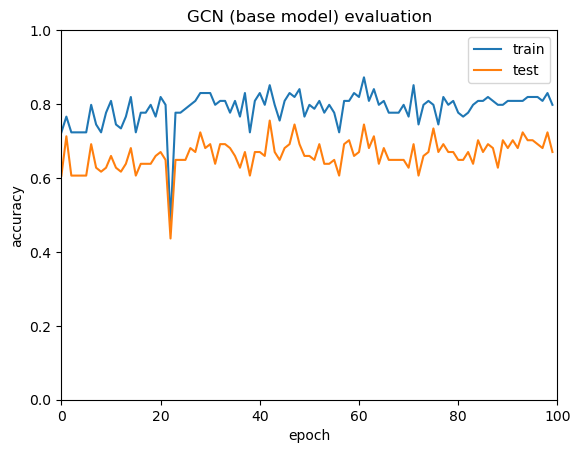

In [138]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(list_train_acc, label='train')
ax.plot(list_test_acc, label='test')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.legend()

plt.xlim([0, 100])
plt.ylim([0, 1.0])

plt.title('GCN (base model) evaluation')
plt.show()

In [139]:
print("average train accuracy", round(sum(list_train_acc)/len(list_train_acc), 4) * 10)
print("average test accuracy", round(sum(list_test_acc)/len(list_test_acc), 4) * 10)

average train accuracy 7.890000000000001
average test accuracy 6.631


In [140]:
print("min test accuracy", round(min(list_test_acc), 4))
print("max test accuracy", round(max(list_test_acc), 4))

min test accuracy 0.4362
max test accuracy 0.7553


In [141]:
import statistics

statistics.median(list_test_acc)

0.6702